isin# Selección de cripto activos para una cartera de inversión

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Práctico 4 - Aprendizaje No Supervisado

# Introducción

En finanzas, encontrar grupos de activos similares o regímenes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definición de reglas de compra/venta, etc. 

En este práctico aplicaremos métodos de aprendizaje no supervisado. Estas metodologías en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener información útil de nuestros datos.

Podemos destacar métodos como clustering y reducción de dimensionalidad. Algunas de las metodologías despliegan su máximo potencial cuando se dispone de grandes cantidades de datos (activos en nuestro caso).

# 📖 ¡Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas específicas de tiempo. Nuestro objetivo será encontrar activos con comportamiento similiar en término de sus retornos.

Para esta actividad seleccionen periodos en los cuales esté disponible la data de todos los activos. 

## Parte I 

Una forma sencilla de predecir el comportamiento de los activos sería suponer que todos siguen el mismo modelo de aprendizaje automático y crear este modelo global para predecir los rendimientos de todos los activos. Sin embargo, es posible que ellos reaccionen de manera diferente a un conjunto de indicadores técnicos. Una forma de resolver este problema es crear un modelo diferente para grupos de activos que se espera que se comporten de manera similar.

Evaluen los siguientes algoritmos de clusterización. 

- Mean Shift.
- k-means. 
- Clustering Jerárquico 

¿Qué activos forman parte de cada cluster? ¿Encuentran alguna relación dentro de cada grupo?

## Parte II 

- Usar la medida de distancia dynamic time warping para agrupar por k-means y comparar con lo obtenido con la métrica euclídea ([link](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3)). Comente los resultados.

## Opcional 

- Aplicar factores dinámicos para ver si las tasas de retorno se pueden resumir en uno o unos pocos constructos subyacentes ([link](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_dfm_coincident.html))

# Fecha de entrega

- __Versión preliminar: 12/9__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

In [1]:
import pandas as pd
import numpy as np

import plotly.graph_objs as go
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

#clusters
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

In [2]:
df = pd.read_csv('../Activos limpios con features - 2tp - Final.csv',index_col='Fecha')

In [3]:
def status(data):

    data2=data 
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)

#### Se toman solo las columnas que se van a tomar para realizar las distintas formas de hacer clustering

In [4]:
columns_interesting = ['profit','close','active']
df_filter = df[columns_interesting]
df_filter

profit        close   active
Fecha                                              
2019-01-01 03:00:00  1.250000      0.35073  XRPUSDT
2019-01-01 03:00:00  2.019584    133.36000  ETHUSDT
2019-01-01 03:00:00  0.702214      2.53830  EOSUSDT
2019-01-01 03:00:00  1.830491      0.04061  ADAUSDT
2019-01-01 03:00:00  1.311806     30.12000  LTCUSDT
...                       ...          ...      ...
2022-05-02 11:00:00  2.492522     30.84000  AXSUSDT
2022-05-02 11:00:00  0.330984  38840.00000  BTCUSDT
2022-05-02 11:00:00  1.110575      2.09400  EOSUSDT
2022-05-02 11:00:00  1.507246     17.51000  NEOUSDT
2022-05-02 11:00:00  0.000000      0.77860  ADAUSDT

[116029 rows x 3 columns]

In [5]:
df_filter.index = pd.to_datetime(df_filter.index)
df_filter

profit        close   active
Fecha                                              
2019-01-01 03:00:00  1.250000      0.35073  XRPUSDT
2019-01-01 03:00:00  2.019584    133.36000  ETHUSDT
2019-01-01 03:00:00  0.702214      2.53830  EOSUSDT
2019-01-01 03:00:00  1.830491      0.04061  ADAUSDT
2019-01-01 03:00:00  1.311806     30.12000  LTCUSDT
...                       ...          ...      ...
2022-05-02 11:00:00  2.492522     30.84000  AXSUSDT
2022-05-02 11:00:00  0.330984  38840.00000  BTCUSDT
2022-05-02 11:00:00  1.110575      2.09400  EOSUSDT
2022-05-02 11:00:00  1.507246     17.51000  NEOUSDT
2022-05-02 11:00:00  0.000000      0.77860  ADAUSDT

[116029 rows x 3 columns]

#### Para poder explorar un poco mejor los cluster se agrupa la recurrencia de cada activo, actualmente tiene recurrencia de cada 4 horas y lo paso a diaria sacando la media tanto del close como la del profit.

In [6]:
contador = 0
for i in set(df_filter.active):
    aux = df_filter[df_filter.active == i]
    aux2 = aux.resample("d").mean()
    aux2['active'] = i
    if contador == 0:
        df_filter_daily = aux2.copy()
        contador += 1
    else:
        df_filter_daily = pd.concat([df_filter_daily, aux2])
        # df_filter_daily = df_filter_daily.dropna()

#### Valido que no queden nan luego del proceso.

In [7]:
status(df_filter_daily)

variable  q_nan  p_nan  q_zeros  p_zeros  unique     type
0   profit      0    0.0        0      0.0   19392  float64
1    close      0    0.0        0      0.0   19132  float64
2   active      0    0.0        0      0.0      19   object

#### Una vez agrupado el set de datos por dia, se realiza el escalado por minimos y maximos por la columna close y profit del 0 al 1 por cada activo , de esta manera podemos realizar cluster en base al rango y comportamiento de cada activo y no por el monto.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
contador = 0
for i in set(df_filter_daily.active):
    aux = df_filter_daily[df_filter_daily.active == i]
    aux[['Scalar_close']] = scaler.fit_transform(aux[["close"]])
    aux[['Scalar_profit']] = scaler.fit_transform(aux[["profit"]])
    if contador == 0:
        df_filter_daily_scalar = aux.copy()
        contador += 1
    else:
        df_filter_daily_scalar = pd.concat([df_filter_daily_scalar, aux])
        # df_filter_daily_scalar = df_filter_daily.dropna()

#### Valido que no queden nan luego del proceso.

In [9]:
status(df_filter_daily_scalar)

variable  q_nan  p_nan  q_zeros  p_zeros  unique     type
0         profit      0    0.0        0  0.00000   19392  float64
1          close      0    0.0        0  0.00000   19132  float64
2         active      0    0.0        0  0.00000      19   object
3   Scalar_close      0    0.0       19  0.00098   19264  float64
4  Scalar_profit      0    0.0       19  0.00098   19358  float64

#### Para poder evaluar de una manera mas visible se toma los 11 criptos con mayor volumen del mercado que analizamos en trabajos anteriores.

In [10]:
criptos = list(['AAVEUSDT', 'AXSUSDT', 'BCHUSDT', 'COMPUSDT', 'DOTUSDT'])
df_filter_daily_scalar_top = df_filter_daily_scalar[~df_filter_daily_scalar.active.isin(criptos)]

In [11]:
df_filter_daily_scalar_top

profit       close   active  Scalar_close  Scalar_profit
Fecha                                                                 
2019-01-01  0.610620    2.561083  EOSUSDT      0.067407       0.532514
2019-01-02  1.084771    2.726583  EOSUSDT      0.083509       0.562185
2019-01-03 -0.981599    2.675333  EOSUSDT      0.078523       0.432875
2019-01-04  0.531243    2.656417  EOSUSDT      0.076682       0.527546
2019-01-05 -0.494980    2.665633  EOSUSDT      0.077579       0.463327
...              ...         ...      ...           ...            ...
2022-04-28  0.190425  231.716667  XMRUSDT      0.443837       0.603384
2022-04-29 -0.982596  225.366667  XMRUSDT      0.429663       0.510476
2022-04-30  0.230592  224.883333  XMRUSDT      0.428584       0.606565
2022-05-01 -0.646131  214.916667  XMRUSDT      0.406338       0.537126
2022-05-02 -0.097035  212.066667  XMRUSDT      0.399976       0.580616

[16095 rows x 5 columns]

### Creamos un nuevo dataframe para dejar sin modificaciones el que ya agrupamos y escalamos.

In [12]:
df_pivot = df_filter_daily_scalar_top
df_pivot

profit       close   active  Scalar_close  Scalar_profit
Fecha                                                                 
2019-01-01  0.610620    2.561083  EOSUSDT      0.067407       0.532514
2019-01-02  1.084771    2.726583  EOSUSDT      0.083509       0.562185
2019-01-03 -0.981599    2.675333  EOSUSDT      0.078523       0.432875
2019-01-04  0.531243    2.656417  EOSUSDT      0.076682       0.527546
2019-01-05 -0.494980    2.665633  EOSUSDT      0.077579       0.463327
...              ...         ...      ...           ...            ...
2022-04-28  0.190425  231.716667  XMRUSDT      0.443837       0.603384
2022-04-29 -0.982596  225.366667  XMRUSDT      0.429663       0.510476
2022-04-30  0.230592  224.883333  XMRUSDT      0.428584       0.606565
2022-05-01 -0.646131  214.916667  XMRUSDT      0.406338       0.537126
2022-05-02 -0.097035  212.066667  XMRUSDT      0.399976       0.580616

[16095 rows x 5 columns]

#### tomamos de todas las columnas solo el nombre del activo y el close escalado para posteriormente utilizarlo para las ejecuciones y validaciones de los cluster

In [13]:
df_pivot = df_pivot[['active','Scalar_close']]
df_pivot

active  Scalar_close
Fecha                            
2019-01-01  EOSUSDT      0.067407
2019-01-02  EOSUSDT      0.083509
2019-01-03  EOSUSDT      0.078523
2019-01-04  EOSUSDT      0.076682
2019-01-05  EOSUSDT      0.077579
...             ...           ...
2022-04-28  XMRUSDT      0.443837
2022-04-29  XMRUSDT      0.429663
2022-04-30  XMRUSDT      0.428584
2022-05-01  XMRUSDT      0.406338
2022-05-02  XMRUSDT      0.399976

[16095 rows x 2 columns]

#### Realizamos el pivot de las columnas para que los diferentes activos sean clusterizados por el comportamiento

In [14]:
df_pivot = df_pivot.pivot(columns='active', values='Scalar_close')
df_pivot = df_pivot.reset_index()

In [15]:
status(df_pivot)

variable  q_nan     p_nan  q_zeros   p_zeros  unique            type
0      Fecha      0  0.000000        0  0.000000    1218  datetime64[ns]
1    ADAUSDT      0  0.000000        1  0.000821    1208         float64
2    BNBUSDT      0  0.000000        1  0.000821    1216         float64
3    BTCUSDT      0  0.000000        1  0.000821    1218         float64
4   DASHUSDT     86  0.070608        1  0.000821    1119         float64
5   DOGEUSDT    185  0.151888        1  0.000821    1027         float64
6    EOSUSDT      0  0.000000        1  0.000821    1212         float64
7    ETCUSDT      0  0.000000        1  0.000821    1216         float64
8    ETHUSDT      0  0.000000        1  0.000821    1216         float64
9   LINKUSDT     15  0.012315        1  0.000821    1196         float64
10   LTCUSDT      0  0.000000        1  0.000821    1207         float64
11  LUNAUSDT    598  0.490969        1  0.000821     616         float64
12   NEOUSDT      0  0.000000        1  0.000821    1214         float64
13   XMRUSDT     73  0.059934        1  0.000821    1138         float64
14   XRPUSDT      0  0.000000        1  0.000821    1215         float64

#### Eliminamos valores en nulos por la diferencias de fecha de creacion de las diferentes criptomonedas y eliminamos la fecha para que no entre en la evaluacion de los cluster

In [16]:
df_pivot = df_pivot.dropna()
df_pivot.drop('Fecha', axis='columns', inplace=True)

In [17]:
df_kmeams = df_pivot
df_kmeams

active   ADAUSDT   BNBUSDT   BTCUSDT  DASHUSDT  DOGEUSDT   EOSUSDT   ETCUSDT  \
598     0.034718  0.025430  0.129307  0.131997  0.002737  0.147109  0.026098   
599     0.033898  0.024850  0.128316  0.128325  0.002697  0.139951  0.025356   
600     0.032958  0.024498  0.128553  0.130803  0.002697  0.140684  0.025575   
601     0.033871  0.025449  0.130395  0.134528  0.002693  0.146032  0.026371   
602     0.031302  0.024522  0.125858  0.122954  0.002554  0.130170  0.024353   
...          ...       ...       ...       ...       ...       ...       ...   
1213    0.275676  0.600821  0.567032  0.148282  0.200322  0.042248  0.223259   
1214    0.266046  0.593493  0.554641  0.142204  0.198051  0.040335  0.212405   
1215    0.257196  0.583511  0.546482  0.132808  0.191675  0.028692  0.199211   
1216    0.253696  0.575728  0.543596  0.125868  0.190283  0.019060  0.190157   
1217    0.255584  0.580984  0.554350  0.129273  0.190234  0.021995  0.193987   

active   ETHUSDT  LINKUSDT   LTCUSDT  LUNAUSDT   NEOUSDT   XMRUSDT   XRPUSDT  
598     0.063377  0.281567  0.086879  0.001306  0.106089  0.143624  0.088649  
599     0.061600  0.302865  0.083824  0.001435  0.110103  0.134458  0.086554  
600     0.061326  0.293664  0.084497  0.001652  0.109279  0.130667  0.087432  
601     0.063884  0.297834  0.090173  0.001877  0.111013  0.134376  0.090078  
602     0.060872  0.285539  0.082859  0.001701  0.102571  0.127322  0.085236  
...          ...       ...       ...       ...       ...       ...       ...  
1213    0.602229  0.245493  0.207133  0.765416  0.115549  0.443837  0.308104  
1214    0.588083  0.236940  0.202235  0.738177  0.109420  0.429663  0.292798  
1215    0.576522  0.225446  0.197577  0.699113  0.104919  0.428584  0.287105  
1216    0.574487  0.215288  0.193447  0.693086  0.101664  0.406338  0.280578  
1217    0.583822  0.215790  0.200458  0.712503  0.103745  0.399976  0.291759  

[620 rows x 14 columns]

#### Transponemos todos los valores de las diferentes criptoactivos y se crea un array con cada valor de los diferentes criptos

In [18]:
df_kmeams = df_kmeams.T.values

In [19]:
df_kmeams

array([[0.03471822, 0.03389789, 0.03295843, ..., 0.25719635, 0.25369587,
        0.25558377],
       [0.0254304 , 0.02485043, 0.02449763, ..., 0.583511  , 0.57572782,
        0.58098399],
       [0.12930719, 0.12831631, 0.12855329, ..., 0.54648238, 0.54359564,
        0.55434966],
       ...,
       [0.10608851, 0.11010269, 0.10927891, ..., 0.10491936, 0.10166385,
        0.10374454],
       [0.14362403, 0.13445756, 0.13066673, ..., 0.42858418, 0.40633766,
        0.39997619],
       [0.08864923, 0.08655444, 0.08743228, ..., 0.28710538, 0.28057762,
        0.29175934]])

In [20]:
from yellowbrick.cluster import KElbowVisualizer

#### Validamos cual seria la cantidad de clusters optimos para este dataset

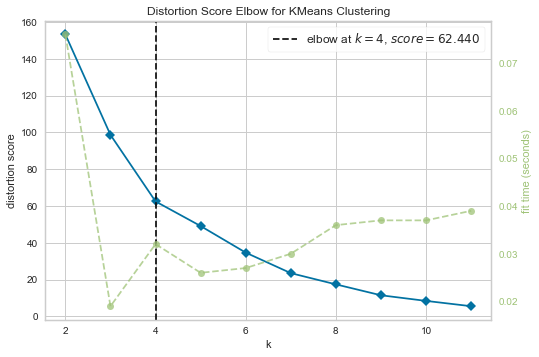

In [21]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_kmeams)
visualizer.show()
plt.show()

### según la validacion podemos ver que con 4 clusters serian suficiente para validar el comportamiento de las diferentes criptos, por lo que una vez obtenido el valor optimo de clusters, se entrena el modelo.

In [22]:
km_4 = KMeans(n_clusters=4,n_init=25, random_state=123)
km_4.fit(df_kmeams)

list_of_centers = km_4.cluster_centers_[:,1].tolist()

In [23]:
df_km_kmeans = pd.DataFrame(columns=df_pivot.columns, data=[km_4.labels_])
df_km_kmeans

active  ADAUSDT  BNBUSDT  BTCUSDT  DASHUSDT  DOGEUSDT  EOSUSDT  ETCUSDT  \
0             0        3        3         0         1        1        1   

active  ETHUSDT  LINKUSDT  LTCUSDT  LUNAUSDT  NEOUSDT  XMRUSDT  XRPUSDT  
0             3         0        0         2        1        0        0

#### luego de realizar la clusterización, tenemos a que grupo pertenece cada cripto por igualdad de comportamiento, ahora vamos agregar este grupo al dataset donde  se encuentra todas las columnas, asi podremos graficar si son grupos con comportamientos similares.  

In [24]:
contador = 0
for i in df_km_kmeans.columns:
    aux = df_filter_daily_scalar_top[df_filter_daily_scalar_top.active == i]
    aux['cluster'] = df_km_kmeans[i][0]
    if contador == 0:
        df_cluster_kmeans = aux.copy()
        contador += 1
    else:
        df_cluster_kmeans = pd.concat([df_cluster_kmeans, aux])

df_cluster_kmeans

profit     close   active  Scalar_close  Scalar_profit  cluster
Fecha                                                                        
2019-01-01  0.753079  0.040842  ADAUSDT      0.005710       0.677493        0
2019-01-02  0.720690  0.043108  ADAUSDT      0.006474       0.674966        0
2019-01-03 -0.434108  0.042657  ADAUSDT      0.006322       0.584853        0
2019-01-04  0.362739  0.042685  ADAUSDT      0.006331       0.647034        0
2019-01-05  0.873916  0.043920  ADAUSDT      0.006748       0.686923        0
...              ...       ...      ...           ...            ...      ...
2022-04-28 -0.304636  0.644417  XRPUSDT      0.308104       0.478368        0
2022-04-29 -0.525248  0.619367  XRPUSDT      0.292798       0.461983        0
2022-04-30 -0.841903  0.610050  XRPUSDT      0.287105       0.438465        0
2022-05-01  0.822043  0.599367  XRPUSDT      0.280578       0.562047        0
2022-05-02 -0.278358  0.617667  XRPUSDT      0.291759       0.480320        0

[16095 rows x 6 columns]

### Validamos rapidamente cual seria la distribucion de cada cluster

In [25]:
df_cluster_kmeans.cluster.value_counts()

0    7134
1    4687
3    3654
2     620
Name: cluster, dtype: int64

In [26]:
aux0 = df_cluster_kmeans[df_cluster_kmeans.cluster == 0]
aux1 = df_cluster_kmeans[df_cluster_kmeans.cluster == 1]
aux2 = df_cluster_kmeans[df_cluster_kmeans.cluster == 2]
aux3 = df_cluster_kmeans[df_cluster_kmeans.cluster == 3]

#### Graficamos todos los cluster para verificar el comportamiento de cada grupo

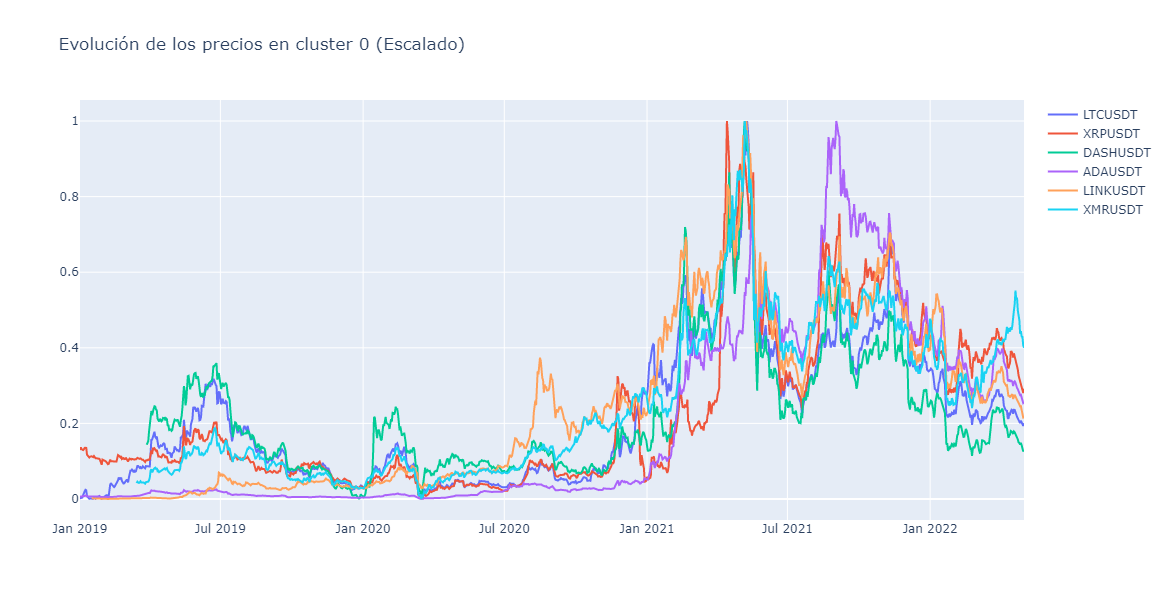

In [27]:
fig = go.Figure()
for active in set(aux0.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

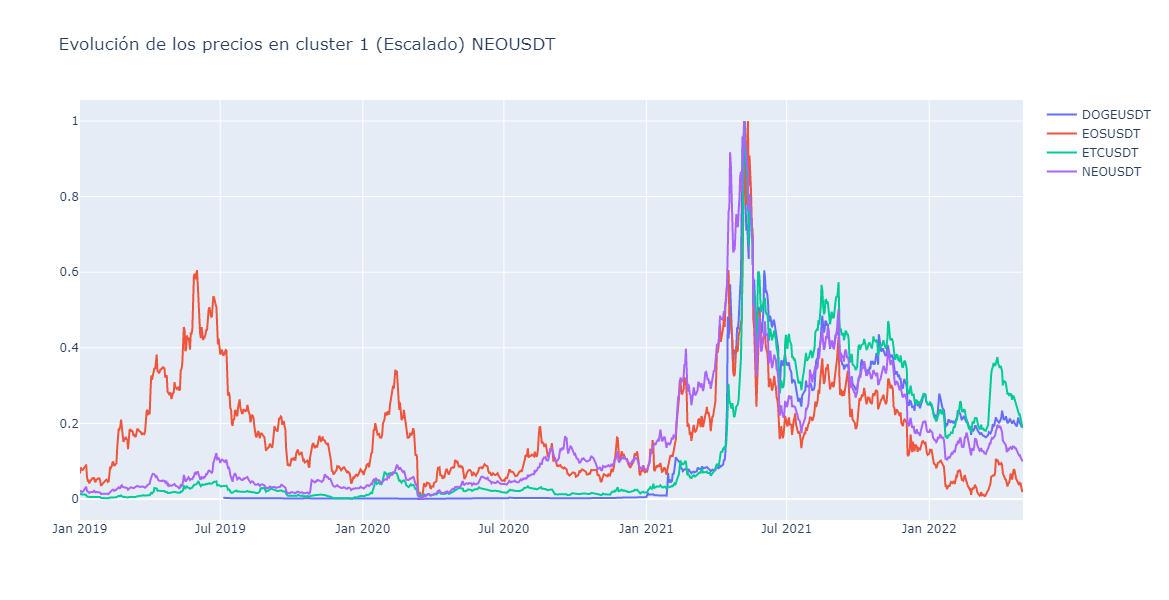

In [28]:
fig = go.Figure()
for active in set(aux1.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 1 (Escalado) '+active,
    width=1100,
    height=600,
    )

fig.show()

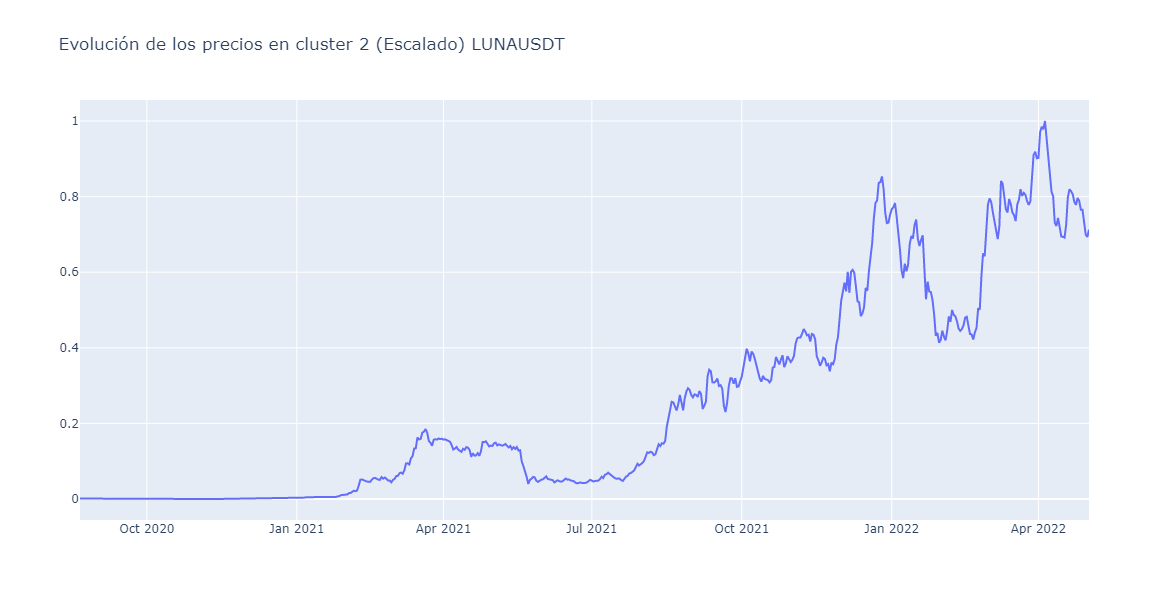

In [29]:
fig = go.Figure()
for active in set(aux2.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 2 (Escalado) ' +active,
    width=1100,
    height=600,
    )

fig.show()

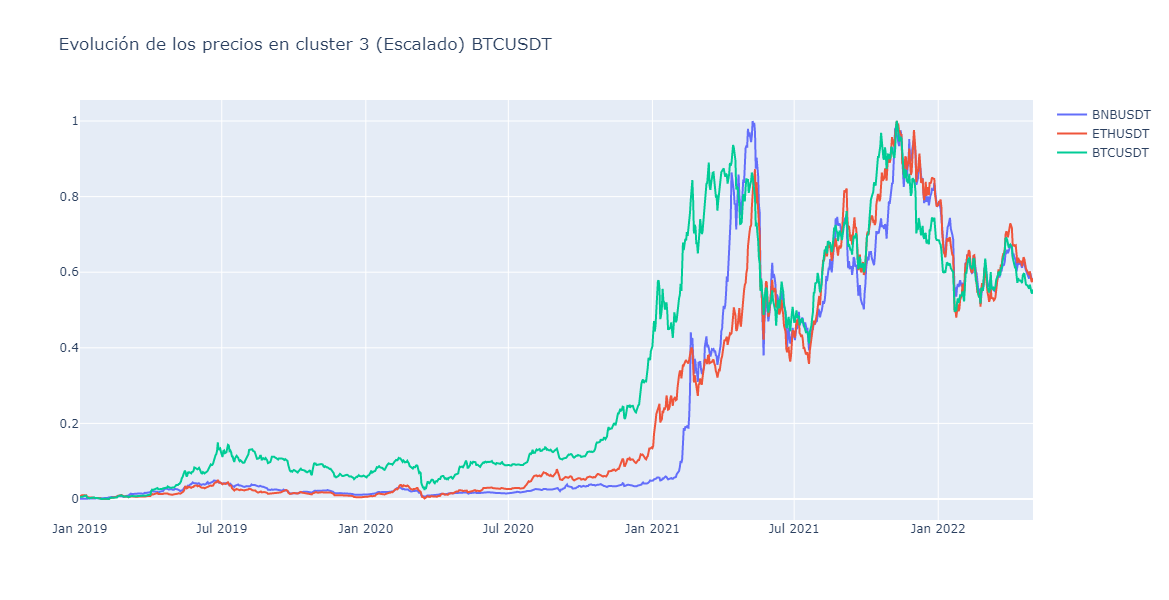

In [30]:
fig = go.Figure()
for active in set(aux3.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 3 (Escalado) '+active,
    width=1100,
    height=600,
    )

fig.show()


#### Podemos concluir que se realizaron cluster con grupos con igual condicion de comportamiento con excepcion de Luna que se agrego en un cluster particular por tener un comportamiento totalmente diferente a las diferentes criptomonedas

# Evaluamos ahora con la función MeanShift

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth
df_MeanShift = df_kmeams

In [32]:
bandwidth = estimate_bandwidth(df_MeanShift, quantile=0.2, n_samples=500)

In [33]:
ms = MeanShift(bandwidth=bandwidth)

ms.fit(df_MeanShift)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

y_pred  = ms.predict(df_MeanShift)

Cantidad de clusters encontrados por Mean Shift : 8


Text(0, 0.5, 'Feature 2')

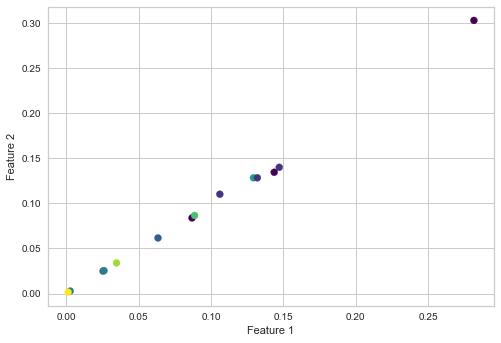

In [34]:
plt.scatter(df_MeanShift[:, 0], df_MeanShift[:, 1], c=y_pred, cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

## Evaluampos distancia euclídea

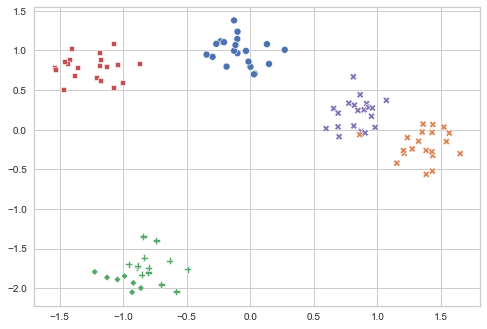

In [35]:
# Info en https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670
# Se modifica Data.

from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random

def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KMeans:
    def __init__(self, n_clusters=6, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, df_kmeams):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(df_kmeams)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, df_kmeams) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(df_kmeams)), size=1, p=dists)
            self.centroids += [df_kmeams[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in df_kmeams:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs
# Create a dataset of 2D distributions
centers = 5
df_kmeams, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42)
df_kmeams = StandardScaler().fit_transform(df_kmeams)
# Fit centroids to dataset
kmeans = KMeans(n_clusters=centers)
kmeans.fit(df_kmeams)
# View results
class_centers, classification = kmeans.evaluate(df_kmeams)
sns.scatterplot(x=[X[0] for X in df_kmeams],
                y=[X[1] for X in df_kmeams],
                hue=true_labels,
                style=classification,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in kmeans.centroids],
         [y for _, y in kmeans.centroids],
         'k+',
         markersize=10,
         )
plt.show()

# D.CLUSTERING JERARQUICO

In [43]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy as  shc

AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

AgglomerativeClustering()

In [106]:
df_pivot

active   ADAUSDT   BNBUSDT   BTCUSDT  DASHUSDT  DOGEUSDT   EOSUSDT   ETCUSDT  \
598     0.034718  0.025430  0.129307  0.131997  0.002737  0.147109  0.026098   
599     0.033898  0.024850  0.128316  0.128325  0.002697  0.139951  0.025356   
600     0.032958  0.024498  0.128553  0.130803  0.002697  0.140684  0.025575   
601     0.033871  0.025449  0.130395  0.134528  0.002693  0.146032  0.026371   
602     0.031302  0.024522  0.125858  0.122954  0.002554  0.130170  0.024353   
...          ...       ...       ...       ...       ...       ...       ...   
1213    0.275676  0.600821  0.567032  0.148282  0.200322  0.042248  0.223259   
1214    0.266046  0.593493  0.554641  0.142204  0.198051  0.040335  0.212405   
1215    0.257196  0.583511  0.546482  0.132808  0.191675  0.028692  0.199211   
1216    0.253696  0.575728  0.543596  0.125868  0.190283  0.019060  0.190157   
1217    0.255584  0.580984  0.554350  0.129273  0.190234  0.021995  0.193987   

active   ETHUSDT  LINKUSDT   LTCUSDT  LUNAUSDT   NEOUSDT   XMRUSDT   XRPUSDT  
598     0.063377  0.281567  0.086879  0.001306  0.106089  0.143624  0.088649  
599     0.061600  0.302865  0.083824  0.001435  0.110103  0.134458  0.086554  
600     0.061326  0.293664  0.084497  0.001652  0.109279  0.130667  0.087432  
601     0.063884  0.297834  0.090173  0.001877  0.111013  0.134376  0.090078  
602     0.060872  0.285539  0.082859  0.001701  0.102571  0.127322  0.085236  
...          ...       ...       ...       ...       ...       ...       ...  
1213    0.602229  0.245493  0.207133  0.765416  0.115549  0.443837  0.308104  
1214    0.588083  0.236940  0.202235  0.738177  0.109420  0.429663  0.292798  
1215    0.576522  0.225446  0.197577  0.699113  0.104919  0.428584  0.287105  
1216    0.574487  0.215288  0.193447  0.693086  0.101664  0.406338  0.280578  
1217    0.583822  0.215790  0.200458  0.712503  0.103745  0.399976  0.291759  

[620 rows x 14 columns]

In [84]:
df_pivot_Jerarq = df_pivot.reset_index()

In [87]:
df_pivot_Jerarq.drop('index', axis='columns', inplace=True)

In [89]:
df_pivot_Jerarq_trans = df_pivot_Jerarq
df_pivot_Jerarq_trans = df_pivot_Jerarq_trans.T
df_pivot_Jerarq_trans

0         1         2         3         4         5    \
active                                                                 
ADAUSDT   0.034718  0.033898  0.032958  0.033871  0.031302  0.030452   
BNBUSDT   0.025430  0.024850  0.024498  0.025449  0.024522  0.025072   
BTCUSDT   0.129307  0.128316  0.128553  0.130395  0.125858  0.125177   
DASHUSDT  0.131997  0.128325  0.130803  0.134528  0.122954  0.120144   
DOGEUSDT  0.002737  0.002697  0.002697  0.002693  0.002554  0.002516   
EOSUSDT   0.147109  0.139951  0.140684  0.146032  0.130170  0.120851   
ETCUSDT   0.026098  0.025356  0.025575  0.026371  0.024353  0.023424   
ETHUSDT   0.063377  0.061600  0.061326  0.063884  0.060872  0.060055   
LINKUSDT  0.281567  0.302865  0.293664  0.297834  0.285539  0.288352   
LTCUSDT   0.086879  0.083824  0.084497  0.090173  0.082859  0.078984   
LUNAUSDT  0.001306  0.001435  0.001652  0.001877  0.001701  0.001712   
NEOUSDT   0.106089  0.110103  0.109279  0.111013  0.102571  0.102914   
XMRUSDT   0.143624  0.134458  0.130667  0.134376  0.127322  0.124692   
XRPUSDT   0.088649  0.086554  0.087432  0.090078  0.085236  0.083482   

               6         7         8         9    ...       610       611  \
active                                            ...                       
ADAUSDT   0.028425  0.028711  0.030434  0.031017  ...  0.294061  0.290690   
BNBUSDT   0.025643  0.026035  0.026577  0.026869  ...  0.604738  0.599507   
BTCUSDT   0.123967  0.125986  0.126956  0.128635  ...  0.567360  0.566185   
DASHUSDT  0.114889  0.117467  0.119484  0.124450  ...  0.164532  0.157808   
DOGEUSDT  0.002421  0.002437  0.002513  0.002514  ...  0.195266  0.191651   
EOSUSDT   0.110951  0.118161  0.124456  0.130995  ...  0.054507  0.049724   
ETCUSDT   0.023379  0.023908  0.024190  0.024186  ...  0.254196  0.247524   
ETHUSDT   0.059761  0.061736  0.063607  0.066907  ...  0.609689  0.605360   
LINKUSDT  0.288041  0.293323  0.319997  0.331774  ...  0.262133  0.260095   
LTCUSDT   0.075022  0.076582  0.078114  0.086725  ...  0.217746  0.213184   
LUNAUSDT  0.001813  0.002237  0.002170  0.002179  ...  0.786268  0.778059   
NEOUSDT   0.102070  0.109067  0.128655  0.134506  ...  0.133540  0.128260   
XMRUSDT   0.124398  0.133010  0.136429  0.138695  ...  0.532711  0.499081   
XRPUSDT   0.077302  0.078816  0.081847  0.085388  ...  0.348982  0.342739   

               612       613       614       615       616       617  \
active                                                                 
ADAUSDT   0.284599  0.280615  0.274862  0.275676  0.266046  0.257196   
BNBUSDT   0.591850  0.587377  0.582930  0.600821  0.593493  0.583511   
BTCUSDT   0.564589  0.560274  0.556335  0.567032  0.554641  0.546482   
DASHUSDT  0.149791  0.148455  0.143885  0.148282  0.142204  0.132808   
DOGEUSDT  0.205599  0.215760  0.202814  0.200322  0.198051  0.191675   
EOSUSDT   0.043205  0.040546  0.036800  0.042248  0.040335  0.028692   
ETCUSDT   0.236264  0.230134  0.223137  0.223259  0.212405  0.199211   
ETHUSDT   0.601712  0.598743  0.592623  0.602229  0.588083  0.576522   
LINKUSDT  0.254314  0.249937  0.245159  0.245493  0.236940  0.225446   
LTCUSDT   0.207373  0.203868  0.200698  0.207133  0.202235  0.197577   
LUNAUSDT  0.796486  0.788607  0.765315  0.765416  0.738177  0.699113   
NEOUSDT   0.120503  0.119003  0.115224  0.115549  0.109420  0.104919   
XMRUSDT   0.482936  0.473226  0.437289  0.443837  0.429663  0.428584   
XRPUSDT   0.326649  0.318471  0.311200  0.308104  0.292798  0.287105   

               618       619  
active                        
ADAUSDT   0.253696  0.255584  
BNBUSDT   0.575728  0.580984  
BTCUSDT   0.543596  0.554350  
DASHUSDT  0.125868  0.129273  
DOGEUSDT  0.190283  0.190234  
EOSUSDT   0.019060  0.021995  
ETCUSDT   0.190157  0.193987  
ETHUSDT   0.574487  0.583822  
LINKUSDT  0.215288  0.215790  
LTCUSDT   0.193447  0.200458  
LUNAUSDT  0.693086  0.712503  
NEOUSDT   0.101664  0.103745  
XMRUSDT   0.406338  0.399976  
XRPUSDT   0

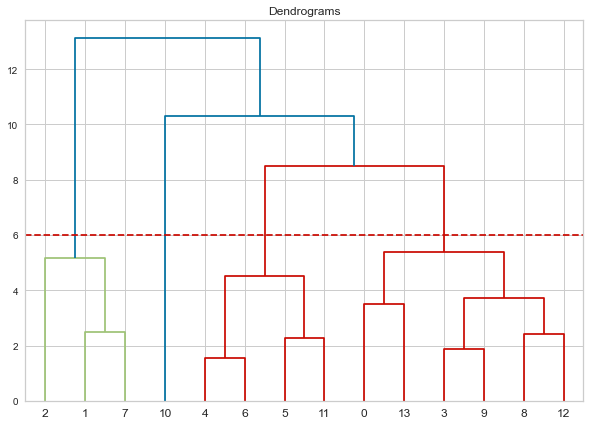

In [93]:
plt.figure(figsize=(10, 7))  

plt.title("Dendrograms")

z = shc.linkage(df_pivot_Jerarq_trans, method='ward')

dend = shc.dendrogram( z )

plt.axhline(y=6, color='r', linestyle='--')

plt.show()

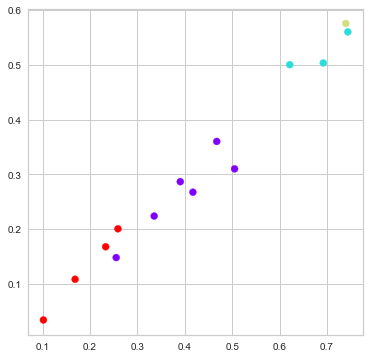

In [94]:
ac2 = AgglomerativeClustering(n_clusters = 4)

#Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(df_pivot_Jerarq_trans[513], df_pivot_Jerarq_trans[520],
          c = ac2.fit_predict(df_pivot_Jerarq_trans), cmap ='rainbow')
plt.show()

In [104]:
c = ac2.fit_predict(df_pivot_Jerarq_trans)
list_of_centers = ac2.labels_.tolist()


[0, 1, 1, 0, 3, 3, 3, 1, 0, 0, 2, 3, 0, 0]

In [110]:
df_Jerarq = pd.DataFrame(columns=df_pivot.columns, data=[ac2.labels_])
df_Jerarq

active  ADAUSDT  BNBUSDT  BTCUSDT  DASHUSDT  DOGEUSDT  EOSUSDT  ETCUSDT  \
0             0        1        1         0         3        3        3   

active  ETHUSDT  LINKUSDT  LTCUSDT  LUNAUSDT  NEOUSDT  XMRUSDT  XRPUSDT  
0             1         0        0         2        3        0        0

In [111]:
contador = 0
for i in df_Jerarq.columns:
    aux = df_filter_daily_scalar_top[df_filter_daily_scalar_top.active == i]
    aux['cluster'] = df_Jerarq[i][0]
    if contador == 0:
        df_cluster_Jerarq = aux.copy()
        contador += 1
    else:
        df_cluster_Jerarq = pd.concat([df_cluster_Jerarq, aux])

df_cluster_Jerarq

profit     close   active  Scalar_close  Scalar_profit  cluster
Fecha                                                                        
2019-01-01  0.753079  0.040842  ADAUSDT      0.005710       0.677493        0
2019-01-02  0.720690  0.043108  ADAUSDT      0.006474       0.674966        0
2019-01-03 -0.434108  0.042657  ADAUSDT      0.006322       0.584853        0
2019-01-04  0.362739  0.042685  ADAUSDT      0.006331       0.647034        0
2019-01-05  0.873916  0.043920  ADAUSDT      0.006748       0.686923        0
...              ...       ...      ...           ...            ...      ...
2022-04-28 -0.304636  0.644417  XRPUSDT      0.308104       0.478368        0
2022-04-29 -0.525248  0.619367  XRPUSDT      0.292798       0.461983        0
2022-04-30 -0.841903  0.610050  XRPUSDT      0.287105       0.438465        0
2022-05-01  0.822043  0.599367  XRPUSDT      0.280578       0.562047        0
2022-05-02 -0.278358  0.617667  XRPUSDT      0.291759       0.480320        0

[16095 rows x 6 columns]

In [115]:
df_cluster_Jerarq.cluster.value_counts()

0    7134
3    4687
1    3654
2     620
Name: cluster, dtype: int64

In [116]:
aux0 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 0]
aux1 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 1]
aux2 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 2]
aux3 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 3]

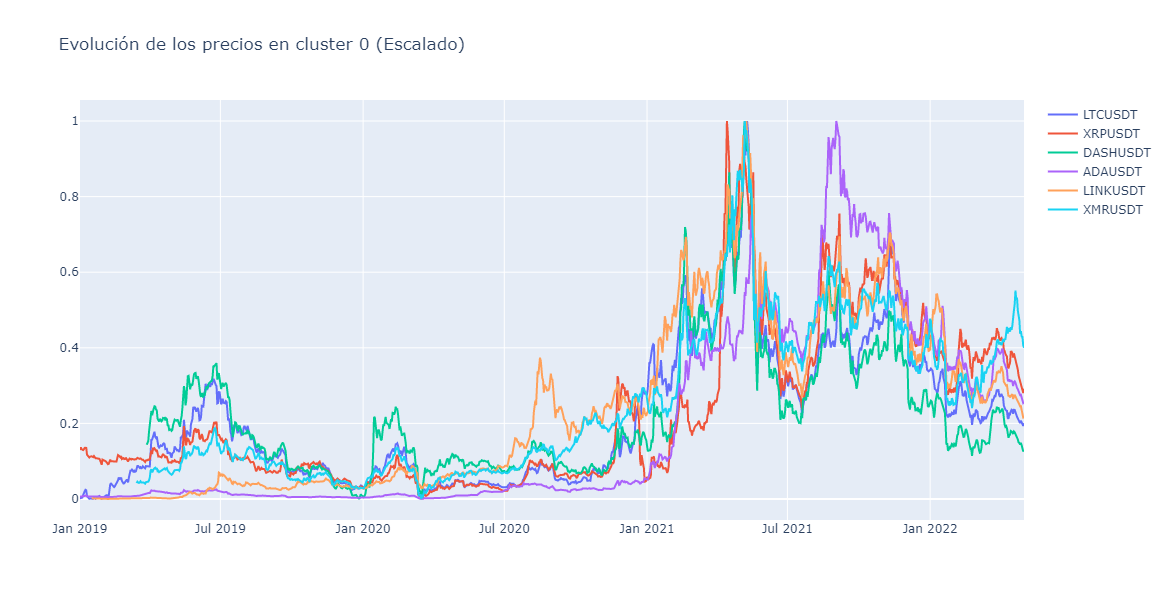

In [117]:
fig = go.Figure()
for active in set(aux0.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

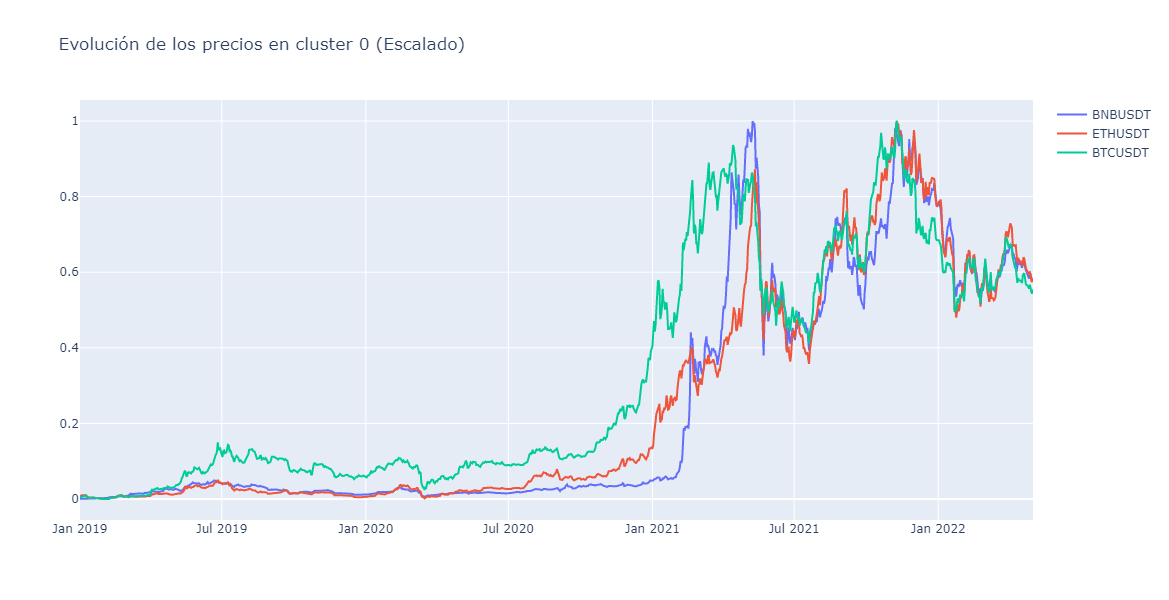

In [118]:
fig = go.Figure()
for active in set(aux1.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

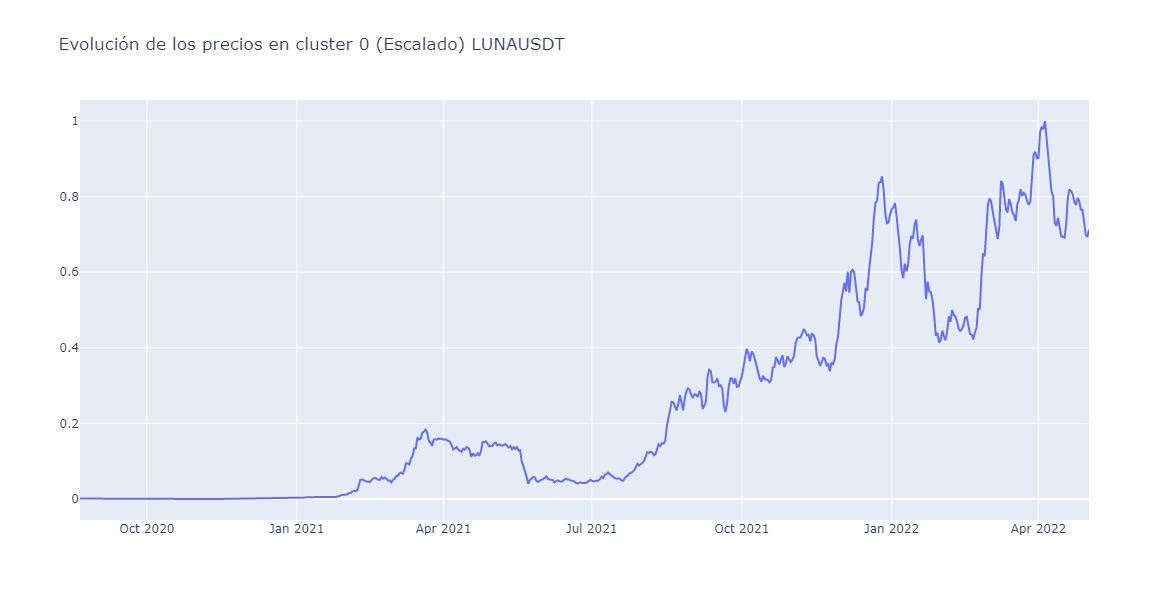

In [120]:
fig = go.Figure()
for active in set(aux2.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado) '+ active,
    width=1100,
    height=600,
    )

fig.show()

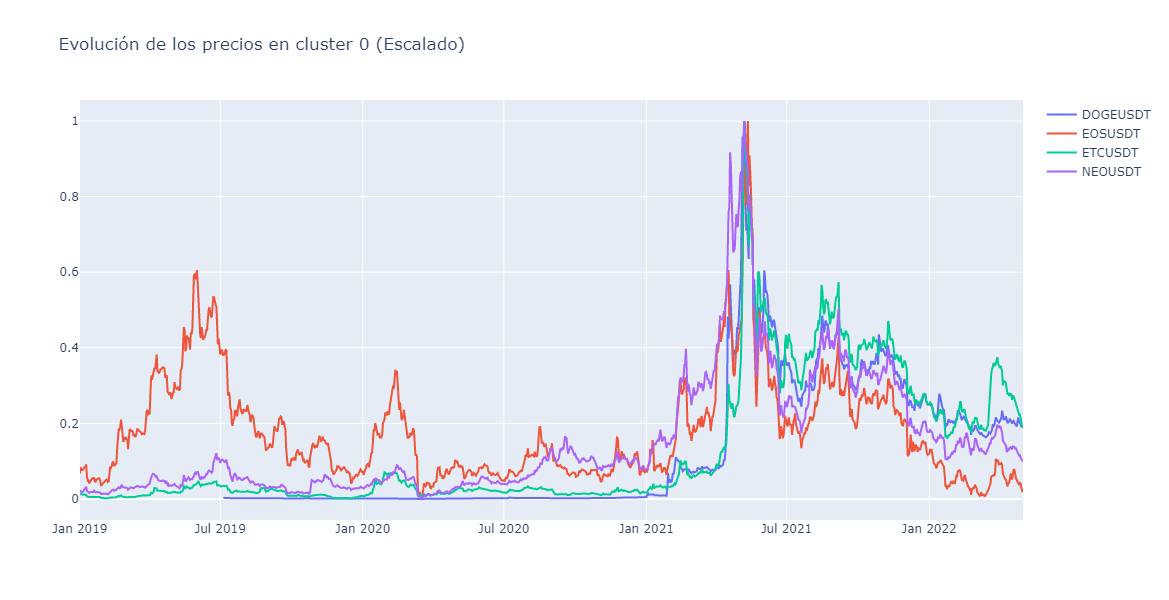

In [122]:
fig = go.Figure()
for active in set(aux3.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evolución de los precios en cluster 0 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()